In [1]:
# ===================================================================
# 📂 1. ENVIRONMENT SETUP & LIBRARY IMPORTS
# ===================================================================
import os
import sys
import warnings
from io import BytesIO
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import requests
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC
from keras.utils import to_categorical

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("✅ Libraries imported successfully!")

2026-01-29 13:03:44.293158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769691824.477099      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769691824.529194      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Libraries imported successfully!


In [2]:
# ===================================================================
# 🗂️ 2. DATASET DIRECTORY SETUP & CLASS DISCOVERY
# ===================================================================
# IMPORTANT: This path assumes you are in a Kaggle environment
# and have added the dataset as described in the instructions.
dataset_root = '/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds'
train_dir = os.path.join(dataset_root, 'Indian_bovine_breeds')
test_dir = os.path.join(dataset_root, 'Indian_bovine_breeds')

# Automatically discover the class names (breed names)
labels = sorted([name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))])
num_classes = len(labels)

print(f"\nFound {num_classes} classes (breeds).")
print("First 5 class names:", labels[:5])


Found 41 classes (breeds).
First 5 class names: ['Alambadi', 'Amritmahal', 'Ayrshire', 'Banni', 'Bargur']


In [3]:
# ===================================================================
# 🧾 3. IMAGE LOADING & PREPROCESSING
# ===================================================================
image_data, label_data = [], []
image_size = 150  # VGG16 works well with this size

label_map = {label: i for i, label in enumerate(labels)}

for data_dir_name in ["Indian_bovine_breeds", "Indian_bovine_breeds"]:
    data_path = os.path.join(dataset_root, data_dir_name)
    print(f"\n📂 Processing '{data_dir_name}' directory...")
    
    for label in tqdm(labels, desc=f'Loading {data_dir_name} images'):
        breed_dir = os.path.join(data_path, label)
        if not os.path.exists(breed_dir):
            continue
            
        for img_file in os.listdir(breed_dir):
            img_path = os.path.join(breed_dir, img_file)
            try:
                image_cv = cv2.imread(img_path)
                if image_cv is None: continue
                
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
                image_cv = cv2.resize(image_cv, (image_size, image_size))
                
                image_data.append(image_cv)
                label_data.append(label_map[label])
            except Exception as e:
                print(f"❌ Error processing file {img_path}: {e}")

print(f"\n✅ Data processing complete! Loaded {len(image_data)} images.")


📂 Processing 'Indian_bovine_breeds' directory...


Loading Indian_bovine_breeds images:  22%|██▏       | 9/41 [00:22<01:18,  2.45s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading Indian_bovine_breeds images:  66%|██████▌   | 27/41 [01:16<00:43,  3.07s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: known incorrect sRGB profile
Loading Indian_bovine_breeds images: 100%|██████████| 41/41 [02:06<00:00,  3.07s/it]



📂 Processing 'Indian_bovine_breeds' directory...


Loading Indian_bovine_breeds images:  22%|██▏       | 9/41 [00:15<00:56,  1.75s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading Indian_bovine_breeds images:  66%|██████▌   | 27/41 [00:54<00:32,  2.33s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: known incorrect sRGB profile
Loading Indian_bovine_breeds images: 100%|██████████| 41/41 [01:29<00:00,  2.19s/it]


✅ Data processing complete! Loaded 11862 images.


In [4]:
# ===================================================================
# 🧪 4. DATA SHUFFLING, NORMALIZATION & SPLITTING
# ===================================================================
image_data, label_data = shuffle(image_data, label_data, random_state=42)
image_data = np.array(image_data, dtype=np.float32) / 255.0
label_data = np.array(label_data, dtype=np.int32)

X_train, X_test, Y_train_raw, Y_test_raw = train_test_split(
    image_data, label_data, test_size=0.2, random_state=42, stratify=label_data
)

Y_train = to_categorical(Y_train_raw, num_classes=num_classes)
Y_test = to_categorical(Y_test_raw, num_classes=num_classes)

print(f"\n✅ Data ready for training!")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")


✅ Data ready for training!
   Training samples: 9489
   Test samples: 2373


Total images are 5949


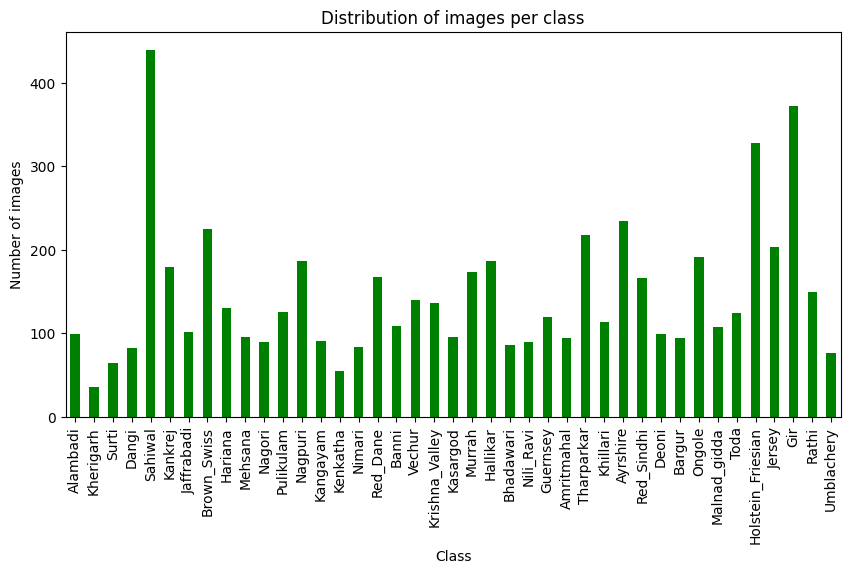

In [5]:
# Get the list of class labels from the training directory
classes = os.listdir(train_dir)

# Count the number of images in each class folder
image_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Calculate and print the total number of images across all classes
total = sum(image_counts.values())
print(f"Total images are {total}")

# Plot a bar chart showing the number of images per class
plt.figure(figsize=(10, 5))
pd.Series(image_counts).plot(kind='bar', color='g')
plt.title('Distribution of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

In [6]:
# ===================================================================
# 🧠 5. VGG16 MODEL CONSTRUCTION WITH TRANSFER LEARNING
# ===================================================================
vgg = VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
print("\n✅ VGG16-based model constructed.")
model.summary()

I0000 00:00:1769692055.907029      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

✅ VGG16-based model constructed.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 41)             │        10,53

 Total params: 19,051,369 (72.68 MB)

 Trainable params: 4,336,681 (16.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# ===================================================================
# ⚙️ 6. MODEL COMPILATION & CALLBACKS CONFIGURATION
# ===================================================================
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', AUC(name='auc')]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

print("\n✅ Model compiled successfully!")


✅ Model compiled successfully!


In [8]:
# ===================================================================
# 🚀 7. MODEL TRAINING
# ===================================================================
print("\n🚀 Starting model training...")
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping, reduce_lr, TqdmCallback(verbose=1)],
    verbose=0
)
print("\n✅ Model training finished!")


🚀 Starting model training...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1769692070.800904     107 service.cc:148] XLA service 0x7dce94007310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769692070.801876     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769692071.250071     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1769692077.299911     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 50: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Restoring model weights from the end of the best epoch: 45.

✅ Model training finished!


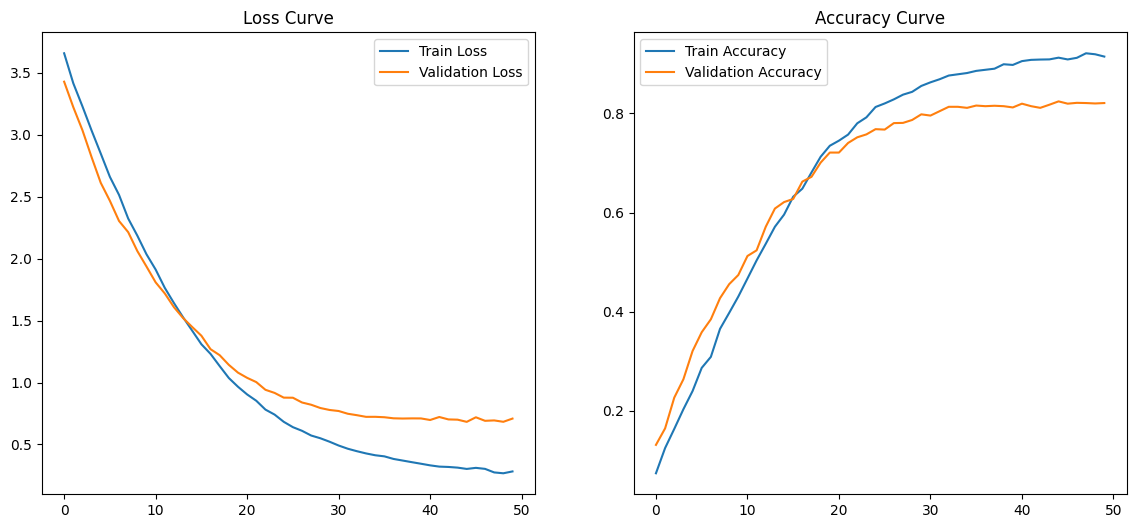

In [9]:
# ===================================================================
# 📈 8. TRAINING METRICS VISUALIZATION
# ===================================================================
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [10]:
# ===================================================================
# 📊 9. CLASSIFICATION REPORT
# ===================================================================
predictions = model.predict(X_test)
y_pred_indices = np.argmax(predictions, axis=1)
print("\nClassification Report:\n")
print(classification_report(Y_test_raw, y_pred_indices, target_names=labels))

# ===================================================================
# 💾 10. SAVING THE TRAINED MODEL
# ===================================================================
model.save("bovine_breed_classifier_vgg16.h5")
print("\n✅ Model saved as 'bovine_breed_classifier_vgg16.h5'")

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step

Classification Report:

                   precision    recall  f1-score   support

         Alambadi       1.00      0.95      0.97        40
       Amritmahal       0.87      0.87      0.87        38
         Ayrshire       0.87      0.88      0.88        94
            Banni       0.59      0.74      0.66        43
           Bargur       0.94      0.84      0.89        37
        Bhadawari       0.57      0.62      0.59        34
      Brown_Swiss       0.92      0.88      0.90        90
            Dangi       0.94      0.94      0.94        33
            Deoni       0.80      0.82      0.81        40
              Gir       0.86      0.85      0.86       149
         Guernsey       0.84      0.90      0.87        48
         Hallikar       0.84      0.92      0.88        74
          Hariana       0.90      0.83      0.86        52
Holstein_Friesian       0.92      0.92      0.92       131
       Jaffrabadi       0.88      0.88      0.88 

In [11]:
# ===================================================================
# 🌐 11. PREDICTION FROM AN IMAGE URL
# ===================================================================
def predict_from_url(url, model, class_names, img_size=(150, 150)):
    print(f"\n🌐 Predicting breed from URL: {url}")
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img_resized = img.resize(img_size)
        img_array = image.img_to_array(img_resized) / 255.0
        img_expanded = np.expand_dims(img_array, axis=0)
        
        preds = model.predict(img_expanded, verbose=0)[0]
        pred_idx = np.argmax(preds)
        pred_class = class_names[pred_idx]
        confidence = preds[pred_idx]
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        top_indices = np.argsort(preds)[-10:][::-1]
        top_probs = preds[top_indices]
        top_classes = [class_names[i] for i in top_indices]
        sns.barplot(x=top_probs, y=top_classes, orient='h')
        plt.title("Top 10 Probabilities")
        plt.xlabel("Probability")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error processing URL: {e}")


🌐 Predicting breed from URL: https://girorganic.com/cdn/shop/articles/what-is-gir-cow-453725.jpg?v=1673547600


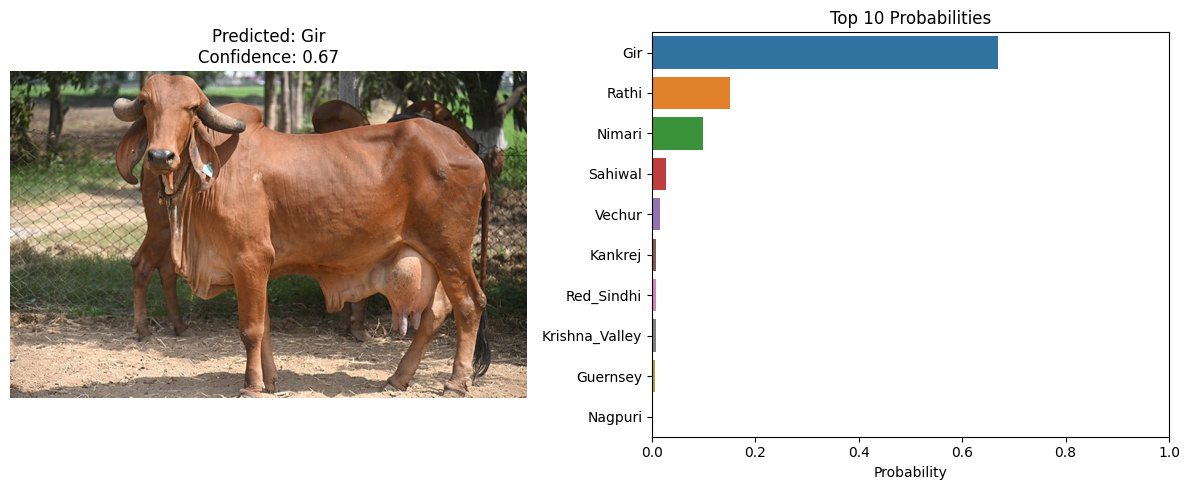

In [12]:
# Example with a Gir Cow image URL
gir_cow_url = "https://girorganic.com/cdn/shop/articles/what-is-gir-cow-453725.jpg?v=1673547600"
predict_from_url(gir_cow_url, model, labels)

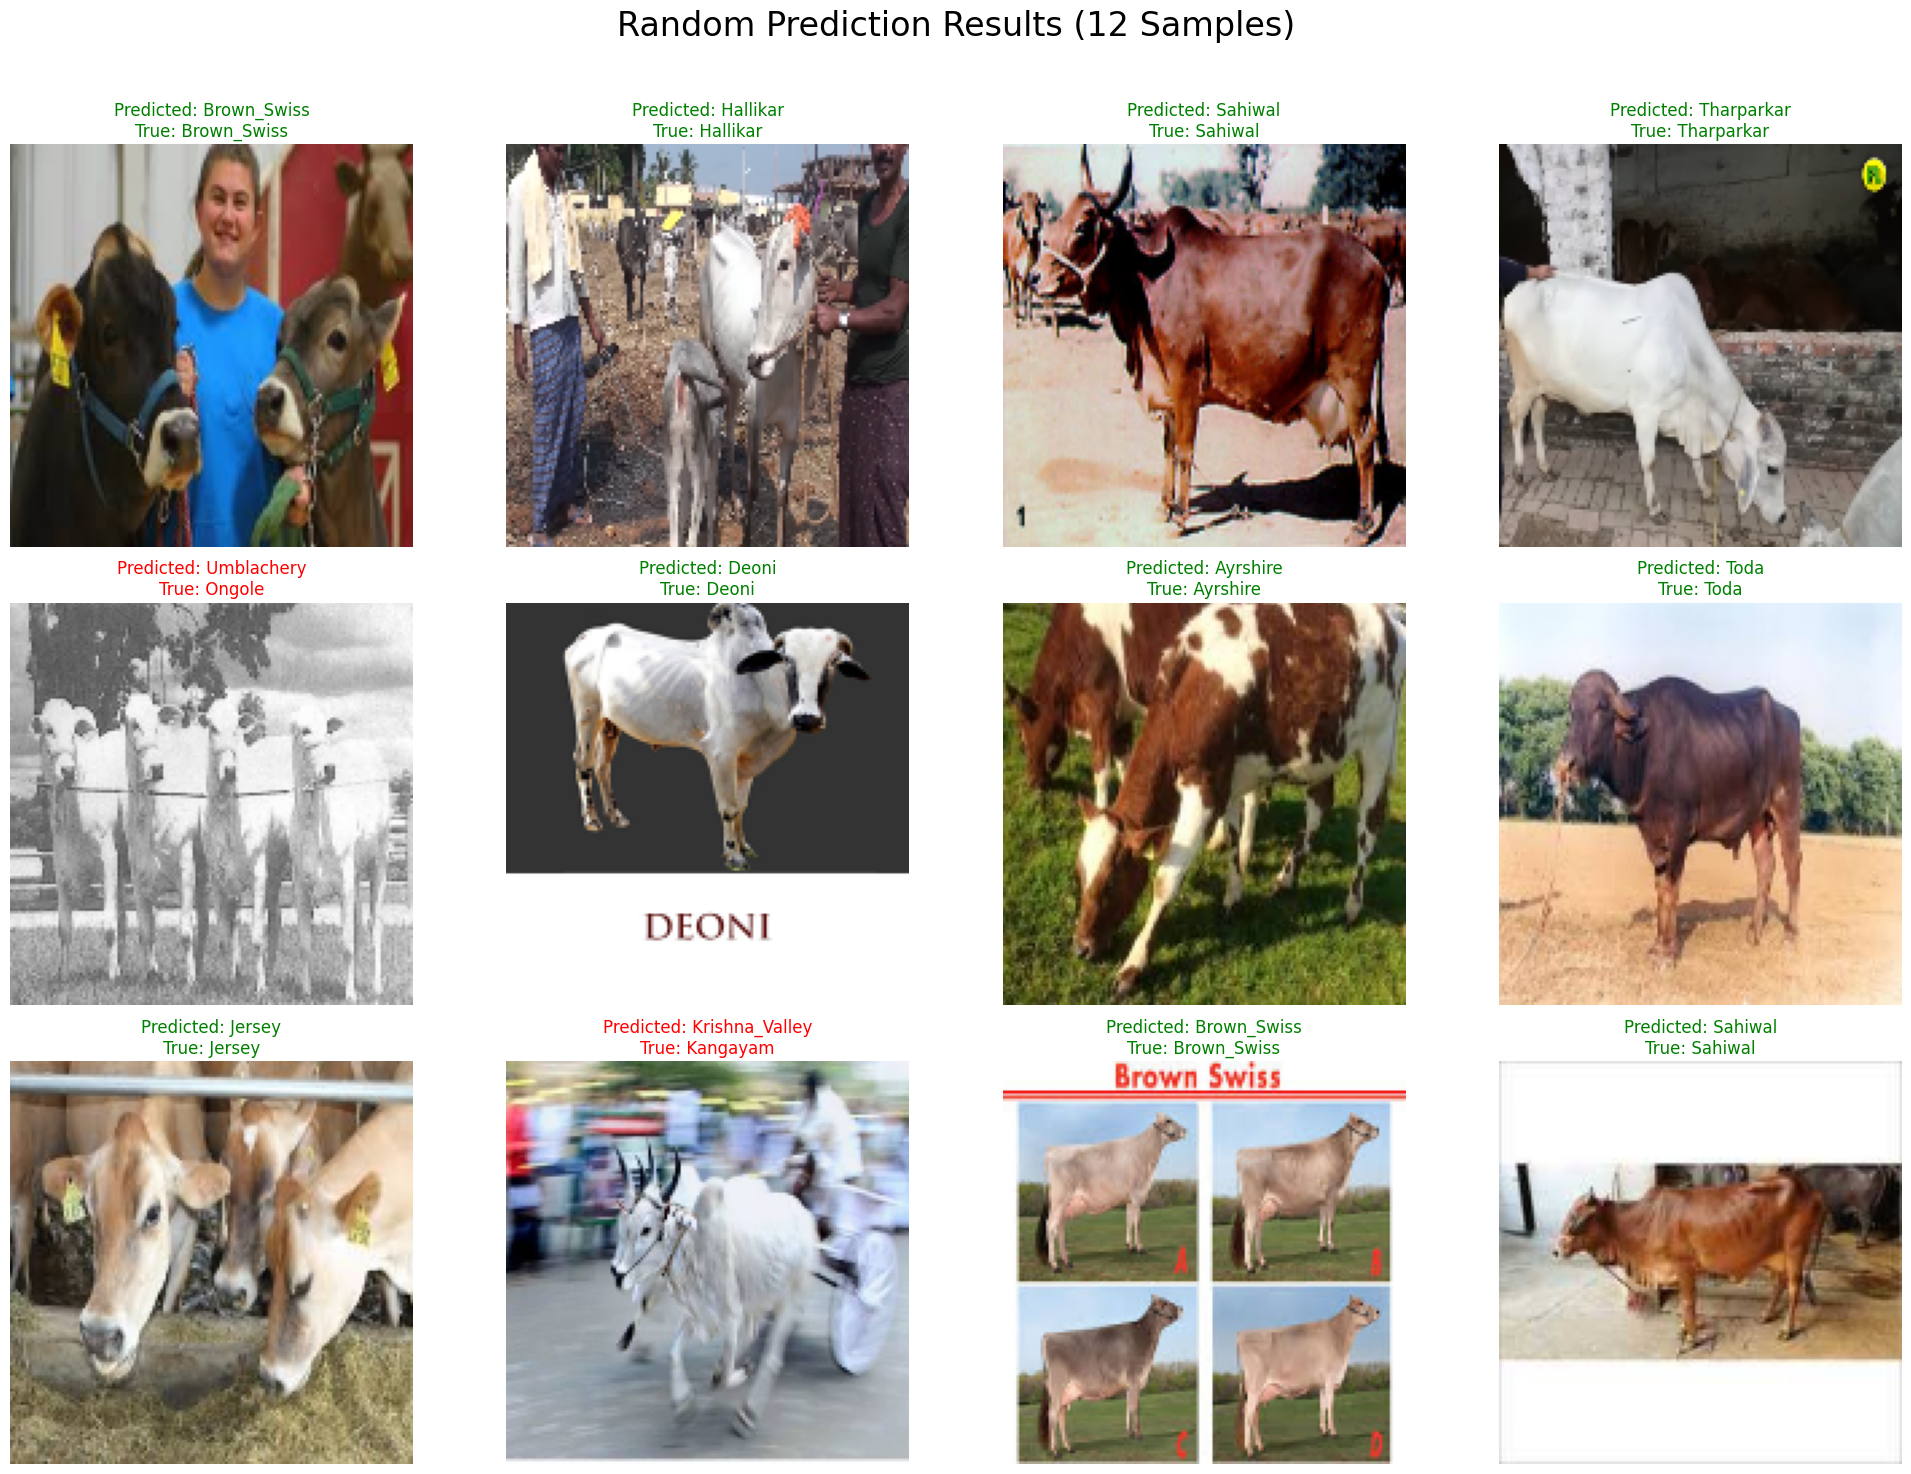

In [13]:
# --- Select 12 random indices from the test set ---
num_test_images = len(X_test)
random_indices = random.sample(range(num_test_images), 12)

# --- Create a figure to display the images ---
plt.figure(figsize=(20, 15))
plt.suptitle("Random Prediction Results (12 Samples)", fontsize=24) # y parameter is removed for auto-placement

# --- Loop through the 12 random indices ---
for i, idx in enumerate(random_indices):
    # Get the image, true label, and prepare for prediction
    test_image = X_test[idx]
    true_label_index = Y_test_raw[idx]
    true_label_name = labels[true_label_index]
    
    # The model expects a batch, so we add a dimension
    image_for_prediction = np.expand_dims(test_image, axis=0)
    
    # --- Make a prediction ---
    prediction = model.predict(image_for_prediction, verbose=0)
    predicted_label_index = np.argmax(prediction)
    predicted_label_name = labels[predicted_label_index]
    
    # --- Determine title color based on correctness ---
    is_correct = (predicted_label_name == true_label_name)
    title_color = "green" if is_correct else "red"
    
    # --- Create a subplot for the image ---
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(test_image)
    ax.set_title(f"Predicted: {predicted_label_name}\nTrue: {true_label_name}", 
                 fontsize=12, 
                 color=title_color)
    ax.axis("off")

# --- Adjust layout and display the plot ---
# The rect parameter prevents the suptitle from overlapping with subplot titles
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()